In [1]:
import numpy as np
import pandas as pd
import json, os, openpyxl, time
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
# from scipy.linalg import cholesky
from numpy.matlib import repmat
# import itertools
from openpyxl.utils.dataframe import dataframe_to_rows     # import the "dataframe_to_rows" function from openpyxl
from importlib import import_module

In [5]:
print('Currently working in: ' + os.getcwd())
# os.chdir(os.getcwd())

Currently working in: C:\Users\Barry\OneDrive - SlateGeotech\Fragility\OpenSRA


In [4]:
%run base.ipynb
# %run uq.ipynb

p(rr_leak≥rr)=∫_(pgv_min  )^(pgv_max)▒∫_(pga_min)^(pga_max)▒〖p(rr_leak≥rr|pga,pgv)*p(pga)*p(pgv)*dpga*dpgv〗


p(rr_leak≥rr)=∑_(j=1)^(n_pgv)▒∑_(i=1)^(n_pga)▒〖p(rr_leak≥rr|pga_i,pgv_j )*p(pga_i )*p(pgv_j )*∆pga_i*∆pgv_j 〗

p(rr_leak≥rr|pga)=∑_(j=1)^(n_pgv)▒〖p(rr_leak≥rr|pgv_j )*p(pgv_j )*∆pgv_j 〗

p(rr_leak≥rr|pgv)=∑_(i=1)^(n_pga)▒〖p(rr_leak≥rr|pga_i )*p(pga_i )*∆pga_i 〗

In [5]:
#####################################################################################################################
### Read EQHazard outputs
#####################################################################################################################
def read_EQHazard_json(path, verbose=False):
	
	## load json file
    with open(EQHaz_file, 'r') as f:
        jd = json.load(f)

    ## set up empty labels for IM dictionary
    im_data = dict([(label, dict()) for label in [
        'site_data', 'im_data', 'im_type', 'site_loc', 'eq_rup'
    ]])

    ## partition json content into a few internal variables for convenience
    eq_info = jd.get('EqRupture',None)
    gm_input = jd.get('GroundMotions',None)

	## items to get from EQHazard output
    im2get = ['SA','PGA','PGV']
    unit2use = ['g','g','cm_s']
    logflag2use = ['ln','ln','ln']
    qnttype2use = ['acc','acc','vel']
    
	## initialize empty arrays
    site_lat = []
    site_long = []
    data_type = []
    data_val = []
    data_source = []
    im_qnt_type = []
    im_unit = []
    im_log_flag = []

	## loop to store site and metadata information
    for i in range(len(gm_input)):
	
		## store longitude and latitude
        site_loc = gm_input[i].get('Location',None)
        if site_loc is not None:
            site_lat.append(site_loc.get('Latitude', None))
            site_long.append(site_loc.get('Longitude', None))
        else:
            site_lat.append(None)
            site_long.append(None)

		## store data type and source
        site_data = gm_input[i].get('SiteData',None)[0]
        if site_data is not None:
            data_type.append(site_data.get('Type', None))
            data_val.append(site_data.get('Value', None))
            data_source.append(site_data.get('Source', None))
        else:
            data_type.append(None)
            data_val.append(None)
            data_source.append(None)
    
	## store IM measures
    for imVar in im2get:
	
		## initialize empty arrays
        im_qnt = []
        im_mean = []
        im_sig_tot = []
        im_sig_intra = []
        im_sig_inter = []
        im_label = []
		
		## loop through all sites
        for i in range(len(gm_input)):
		
			## try to find target items specified in "im2get" and store them
            try:
                j_val = next(j_val for _, j_val in enumerate(gm_input[i].keys()) if imVar in j_val)
                im_qnt = gm_input[i][j_val]
                im_label = j_val
            except:
                im_qnt = None
                im_label = None

			## if target IM measure is available, further partition its content into mean and sigma
            if im_qnt is not None:
                im_mean.append(im_qnt.get('Mean', None))
                im_sig_tot.append(im_qnt.get('TotalStdDev', None))
                im_sig_intra.append(im_qnt.get('IntraEvStdDev', None))
                im_sig_inter.append(im_qnt.get('InterEvStdDev', None))
            else:
                im_mean.append(None)
                im_sig_tot.append(None)
                im_sig_intra.append(None)
                im_sig_inter.append(None)

		## if specral acceleration is specified, also store period
        if 'SA' in imVar and im_mean is not None:
            im_period = jd.get('Periods',None)
            im_data['im_data'].update({'period': im_period,
                                       imVar.lower()+'_mean': im_mean,
                                       imVar.lower()+'_sig_total': im_sig_tot,
                                       imVar.lower()+'_sig_intra': im_sig_intra,
                                       imVar.lower()+'_sig_inter': im_sig_inter})
        else:
            im_data['im_data'].update({imVar.lower()+'_mean': im_mean,
                                       imVar.lower()+'_sig_total': im_sig_tot,
                                       imVar.lower()+'_sig_intra': im_sig_intra,
                                       imVar.lower()+'_sig_inter': im_sig_inter})

		## see if other information are provided (e.g., units, if values are in log)
        try:
            next(j for i, j in enumerate(gm_input[0].keys()) if imVar in j)
            im_qnt_type.append(qnttype2use[i])
            im_unit.append(unit2use[i])
            im_log_flag.append(logflag2use[i])
        except:
            pass

	## update the IM data dictionary
    im_data['im_type'].update({'type': im_qnt_type,
                               'unit': im_unit,
                               'log_flag': im_log_flag})

    im_data['eq_rup'].update(eq_info)

    im_data['site_loc'].update({'latitude': site_lat,
                                'longitude': site_long})

    im_data['site_data'].update({'vs30': data_val,
                                 'source': data_source})

	##
    return im_data

In [6]:
#####################################################################################################################
### Reading json files that have been created manually
#####################################################################################################################
def read_other_site_data(path, var, verbose=False):
	##
    with open(path, 'r') as f:
        jd = json.load(f)

	##
    site = jd.get('Site',None)
    site_list = site.get('SiteList',None)
	
	##
    data2get = []
	
	##
    for i in range(len(site_list)):
        if site_list[i][var] is not None:
            data2get.append(site_list[i][var])
        else:
            data2get.append(np.nan)
	
	##
    return data2get

In [7]:
#####################################################################################################################
##### Calculate the epicentral distances using the Haversine equation
#####################################################################################################################
def get_haversine_dist(lat1,long1,lat2,long2,z=0,unit='km',unit='degree'):
	
	## determine unit to reference for Earth's radius
	if unit == 'km':
		r = 6371 # km
	elif unit == 'miles':
		r = 3,958.8
		
	## check if in radians or degrees, assume to be in degrees by default
    if 'deg' in unit.lower():
	
		## convert long lat from degrees to radians
		lat1 = np.log(lat1)
		long1 = np.log(long1)
		lat2 = np.log(lat2)
		long2 = np.log(long2)
	
    ## Haversine function for epicentral distance
    d = 2*r*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((long2-long1)/2)**2))
		
	##
	return d

In [8]:
#####################################################################################################################
##### get spatial correlations (between sites)
##### Jayaram & Baker (2009) Correlation model for spatially distributed ground-motion intensities
#####################################################################################################################
def get_corr_spatial(h, T, unit='km', geo_cond=2):
    # geo_cond = 1: variability within soil
    # geo_cond = 2: homogenious condition
    # h must be in km
    if T < 1:
        if geo_cond == 1:
            b = 8.5 + 17.2*T
        if geo_cond == 2:
            b = 40.7 - 15.0*T
    elif T >= 1:
        b = 22.0 + 3.7*T

	##
    return np.exp(-3*h*globals()[unit]/globals()['km']/b)

In [9]:
#####################################################################################################################
##### get spectral correlations (between periods)
##### Jayaram & Baker (2009) Correlation of Spectral Acceleration Values from NGA Ground Motion Models
#####################################################################################################################
def get_corr_spectral(T1, T2):

	## figure out which is bigger
    Tmax = max(T1,T2)
    Tmin = min(T1,T2)
    
	## calculate correlations
    C1 = 1 - np.cos(np.pi/2 - 0.366*np.log(Tmax/max(Tmin,0.109)))
    if Tmax < 0.2:
        C2 = 1 - 0.105*(1 - 1/(1+np.exp(100*Tmax-5)))*((Tmax-Tmin)/(Tmax-0.0099))
    else:
        C2 = 0
    if Tmax < 0.109:
        C3 = C2
    else:
        C3 = C1
    C4 = C1 + 0.5*(np.sqrt(C3) - C3)*(1 + np.cos(np.pi*Tmin/0.109))
    
	## return the right correlation based on period amplitudes
    if Tmax < 0.109:
        return C2
    elif Tmin > 0.109:
        return C1
    elif Tmax < 0.2:
        return min(C2,C4)
    else:
        return C4

In [10]:
#####################################################################################################################
##### trapezoidal integration function
#####################################################################################################################
def inte_trap(y,x=None,inte_max=None):
	
	## check if x values are given (non-uniform time step)
    if x is None:
        x = range(len(y)) ## time-step = 1
	
	## initialize array
    inte_y = np.zeros(len(y))
	
	## integrate 
    for i in range(1,len(y)):
        inte_y[i] = inte_y[i-1] + (y[i-1] + y[i])/2 * (x[i]-x[i-1])
	
	## in case integration goes beyond 1 (need better way of checking for total sum)
    if inte_max is not None:
        inte_y = np.clip(inte_y,None,inte_max)
	
	##
    return inte_y

In [11]:
#####################################################################################################################
##### count number of instances in a given range
#####################################################################################################################
def count_in_range(vect, a=-np.inf, b=np.inf, a_flag=True, b_flag=True):
	## upper limit
    if a_flag is True:
        count_a = sum([1 if i >= a else 0 for i in vect])
    else:
        count_a = sum([1 if i > a else 0 for i in vect])
		
	## lower limit
    if b_flag is True:
        count_b = sum([1 if i > b else 0 for i in vect])
    else:
        count_b = sum([1 if i >= b else 0 for i in vect])
		
	##
    return count_a-count_b

In [12]:
#####################################################################################################################
##### sort list where each index has multiple elements, sort by column index
#####################################################################################################################
def sort(arr,col):

	##
    return(sorted(arr, key = lambda x: x[col]))

In [13]:
#####################################################################################################################
##### get random combination, for LHS
#####################################################################################################################
def genRandComb(nBin,nVar):

	## initialize array
    comb = np.zeros((nBin, nVar))
	
	## find permunation given number of bins
    comb[0:,0] = np.random.permutation(np.arange(nBin))
	
	## loop and determine corresponding pairs, remove permutation when already selected
    for i in range(1,nVar):
        for j in range(nBin):
            choice = np.arange(nBin)
            usedVal = np.unique(np.append(np.transpose(comb[j,0:i]),comb[0:j,i]))
            ind2del = [next(ii for ii, jj in enumerate(choice) if jj == kk) for kk in usedVal]
            choice2 = np.delete(choice,ind2del)
            comb[j,i] = np.random.permutation(choice2)[0]
			
	## 
    return comb

In [25]:
def assess_pipe_segment_Hazus(sa_1, pga, pgv, m, d_w, susc_liq, susc_land, pipe_type='brittle', l_seg=1):
    """
    Following the Hazus (FEMA, 2003) methodology

    Parameters
    ----------
    Sa @ T = 1s, Sa_1
    Peak ground acceleration, pga
    Moment magnitude, m
    Depth to ground water, d_w
    Susceptibility category for LIQUEFACTION, susc_liq = none, very low, low, moderate, high, very high
    Susceptibility category for LANDSLIDE, susc_land = 0 to 10
    Pipe type, pipe_type = brittle or ductile 

    Returns
    -------
    Inferred PGV, pgv_in
    Liquefaction likelihood, p_liq
    Peak ground displacement for lateral spread, pgd_ls
    Ground settlement, pgd_gs
    Peak ground displacement for landslide, pgd_land
    Maximum displacement for surface fault rupture, pgd_sfr
    Repair_rate by PGV, rr_pgv
    Repair rate by PGD, rr_pgd

    """
    
    ## Initialize dictionary
    dm_out = {}
    
    ## Load Makdisi & Seed digitized data
    file_makdisi_seed = 'makdisi_seed_dig.txt'
    makdisi_seed = pd.read_csv(file_makdisi_seed, sep='\t')
    makdisi_seed_keys = makdisi_seed.keys()

    ## conjugate distribution for repair rates
    ln_rr_mean = np.log(0.1)
    ln_rr_beta = 0.85
    
    # Standard deviation of PGD
    # stdev_ln_pgd_ls = 0.5 # assumed/placeholder
    # stdev_ln_pgd_gs = 0.5 # assumed/placeholder
    # stdev_ln_pgd_land = 0.5 # assumed/placeholder
    # stdev_ln_pgd_sfr = 0.35 * np.log(10) # given in Hazus
    
    # Inferred PGV from Sa(T=1s)
#     if pgv is not None:
#         pgv = pgv['mean']
#     else:
#         pgv = globals()['g']*sa_1['mean']/2/np.pi/1.65 / globals()['cm'] # requires Sa in units of g - factor of 1.65 from Newmark and Hall (1982) for 5% velocity response spectrum
    
    # Correlations based on liquefaction susceptibility
    if susc_liq.lower() == 'very high':
        p_liq_pga = np.maximum(np.minimum(9.09*pga-0.82,1),0)
        p_ml = 0.25
        pga_t = 0.09 # g
        pgd_gs = 12 # inches
    elif susc_liq.lower() == 'high':
        p_liq_pga = np.maximum(np.minimum(7.67*pga-0.92,1),0)
        p_ml = 0.20
        pga_t = 0.12 # g
        pgd_gs = 6 # inches
    elif susc_liq.lower() == 'moderate':
        p_liq_pga = np.maximum(np.minimum(6.67*pga-1.00,1),0)
        p_ml = 0.10
        pga_t = 0.15 # g
        pgd_gs = 2 # inches
    elif susc_liq.lower() == 'low':
        p_liq_pga = np.maximum(np.minimum(5.57*pga-1.18,1),0)
        p_ml = 0.05
        pga_t = 0.21 # g
        pgd_gs = 1 # inches
    elif susc_liq.lower() == 'very low':
        p_liq_pga = np.maximum(np.minimum(4.16*pga-1.08,1),0)
        p_ml = 0.02
        pga_t = 0.26 # g
        pgd_gs = 0 # inches
    elif susc_liq.lower() == 'none':
        p_liq_pga = np.ones(len(pga))*0.00
        p_ml = 0.00
        pga_t = 999. # g
        pgd_gs = 0 # inches
    else:
        p_liq_pga = np.ones(len(pga))*np.nan
        p_ml = np.nan
        pga_t = np.nan
        pgd_gs = np.nan

    # Liquefaction likelihood, p_liq    
    k_m = 0.0027 * m**3 - 0.0267 * m**2 - 0.2055 * m + 2.9188
    k_w = 0.022 * d_w + 0.93
    p_liq = p_liq_pga / k_m / k_w * p_ml
    
    # Critical PGA based on landslide susceptibility
    pga_c = [0.60 if susc_land == 1 else
             0.50 if susc_land == 2 else
             0.40 if susc_land == 3 else
             0.35 if susc_land == 4 else
             0.30 if susc_land == 5 else
             0.25 if susc_land == 6 else
             0.20 if susc_land == 7 else
             0.15 if susc_land == 8 else
             0.10 if susc_land == 9 else
             0.05 if susc_land == 10 else 999]
    pga_c = pga_c[0]

    ### Peak ground deformations (pgd):    
    # PGD for lateral spread
    k_delta = 0.0086 * m**3 - 0.0914 * m**2 + 0.4698 * m - 0.9835
    pgd_pga_pgat = np.asarray([12*max(j/pga_t,1)-12 if j/pga_t<=2
                              else 18*j/pga_t-24 if j/pga_t>2 and j/pga_t<=3
                              else 70*min(j/pga_t,4)-180
                              for j in pga])  # inches
    pgd_ls = k_delta*pgd_pga_pgat # inches
    
    # PGD for ground settlement (Tokimatsu and Seed, 1987)
    pgd_gs = np.ones(len(pga))*pgd_gs # see decision tree above
    
    # Average PGD due to liquefaction-induced deformation
    pgd_liq = np.sqrt(pgd_ls*pgd_gs)
    
    # PGD for landslide
    n_cyc = 0.3419 * m**3 - 5.5214 * m**2 + 33.6154 * m - 70.7692
    pga_is = pga # default - pga_is = pga
    pgd_pgais_n_upper = np.interp(pga_c/pga_is,makdisi_seed[makdisi_seed_keys[0]],makdisi_seed[makdisi_seed_keys[1]]) 
    pgd_pgais_n_lower = np.interp(pga_c/pga_is,makdisi_seed[makdisi_seed_keys[2]],makdisi_seed[makdisi_seed_keys[3]])
    pgd_pgais_n = (pgd_pgais_n_upper + pgd_pgais_n_lower)/2
    pgd_land = pgd_pgais_n * pga_is * n_cyc * globals()['cm']/globals()['inch'] # 

    # PGD for surface fault rupture
    pgd_sfr = np.ones(len(pga))* 10**(-5.26 + 0.79*m) * globals()['m']/globals()['inch']
    
    # correction factor for ductility of pipes
    rr_multi = [0.3 if pipe_type == 'ductile' else 1]

    # Repair rates by PGV and PGD
    rr_pgv = 0.0001 * pgv**2.25 * rr_multi # PGV in cm/s, repair rate in repairs/km
    rr_pgd_liq = p_liq * pgd_liq**0.56 * rr_multi # PGD in inches, repair rate in repairs/km, using only liquefaction-induced deformation for now
    rr_pgd = rr_pgd_liq # for now set repair rate by PGD to rr_pgd_liq, since the empirical formula for rr_pgd is a function of the
                        # probability of liquefaction and shouldn't be associated with landslide and surface fault rupture
    
    rr_leak = rr_pgv*0.8 + rr_pgd*0.2
    rr_break = rr_pgv*0.2 + rr_pgd*0.8
#     rr_leak = rr_pgd
#     rr_break = rr_pgd
    
    n_pgv = rr_pgv*l_seg
    n_pgd = rr_pgd*l_seg
    n_leak = rr_leak*l_seg
    n_break = rr_break*l_seg
    
    return rr_pgv, rr_pgd, rr_leak, rr_break, n_pgv, n_pgd, n_leak, n_break

In [15]:
class Assessment(object):
    def __init__(self):

        # initialize the basic data containers
        # inputs
        self._IM_in = None
#         self._EDP_in = None
#         self._POP_in = None
#         self._FG_in = None

        # random variables and loss model
        self._RV_dict = None # dictionary to store random variables
        self._IM_dict = None # dictionary to store random variables
        self._EDP_dict = None
        self._DM_dict = None
        self._FR_dict = None

        # results
        self._TIME = None
        self._POP = None
        self._COL = None
        self._ID_dict = None
        self._DMG = None
        self._DV_dict = None
        self._SUMMARY = None

        self._assessment_type = 'generic'
    
    def read_inputs(self, path_IM_input, path_json, verbose=False):
        """
        Read and process the input files to describe the assessment task.

        Parameters
        ----------
        path_Im_input: string
            Name of the intensity measure input file with relative path. The file
            is expected to be a JSON with data stored in a standard format described
            in detail in the Input section of the documentation.
        
        verbose: boolean, default: False
            If True, the method echoes the information read from the files.
            This can be useful to ensure that the information in the file is
            properly read by the method.

        """
        self._IM_in = read_EQHazard_json(EQHaz_file, verbose=verbose)
        
        self._IM_in['site_data'].update({'l_seg': read_other_site_data(path_json,'LSegment')})
        self._IM_in['site_data'].update({'liq_susc': read_other_site_data(path_json,'LiqSusc')})
        self._IM_in['site_data'].update({'ls_susc': read_other_site_data(path_json,'LsSusc')})
        self._IM_in['site_data'].update({'d_w': read_other_site_data(path_json,'Z2gw')})

    def _define_random_variables(self, realization_count):
        """
        Define the random variables used for assessment.

        """
        # create the random variables -----------------------------------------
        self._RV_dict = {}

        # intensity measures
        site_loc = self._IM_in.get('site_loc', None)

        im_data = self._IM_in.get('im_data', None)
        period = im_data.get('period', None)
        SA_mean = im_data.get('sa_mean', None)
        SA_std_tot = im_data.get('sa_std_total', None)
        SA_std_intra = im_data.get('sa_std_intra', None)
        SA_std_inter = im_data.get('sa_std_inter', None)
        
        sites = []
        SA_1_mean = []
        SA_1_std_tot = []
        SA_1_std_intra = []
        SA_1_std_inter = []
        Sa_1_id = []

        for i in range(len(SA_mean)):
            site_lat = site_loc['latitude'][i]
            site_long = site_loc['longitude'][i]
            sites.append([site_lat, site_long])

            SA_1_mean.append(np.interp(1, period, SA_mean[i]) if SA_mean is not None else None)
            SA_1_std_tot.append(np.interp(1, period, SA_std_tot[i]) if SA_std_tot is not None else None)
            SA_1_std_intra.append(np.interp(1, period, SA_std_intra[i]) if SA_std_intra is not None else None)
            SA_1_std_inter.append(np.interp(1, period, SA_std_inter[i]) if SA_std_inter is not None else None)

            Sa_1_id.append('sa_1-site' + str(i+1))

        self._RV_dict.update({'sa_1': self._create_RV(Sa_1_id, SA_1_mean, SA_1_std_tot, SA_1_std_intra, SA_1_std_inter, sites)})
        
        PGA_mean = []
        PGA_std_tot = []
        PGA_std_intra = []
        PGA_std_inter = []
        PGA_id = []
        
        PGA_mean = im_data.get('pga_mean', None)
        PGA_std_tot = im_data.get('pga_std_total', None)
        PGA_std_intra = im_data.get('pga_std_intra', None)
        PGA_std_inter = im_data.get('pga_std_inter', None)
        
        for i in range(len(PGA_mean)):
            PGA_id.append('pga-site' + str(i+1))

        self._RV_dict.update({'pga': self._create_RV(PGA_id, PGA_mean, PGA_std_tot, PGA_std_intra, PGA_std_inter, sites)})
        
        PGV_mean = []
        PGV_std_tot = []
        PGV_std_intra = []
        PGV_std_inter = []
        PGV_id = []
        
        PGV_mean = im_data.get('pgv_mean', None)
        PGV_std_tot = im_data.get('pgv_std_total', None)
        PGV_std_intra = im_data.get('pgv_std_intra', None)
        PGV_std_inter = im_data.get('pgv_std_inter', None)
        
        for i in range(len(PGV_mean)):
            PGV_id.append('pgv-site' + str(i+1))

        self._RV_dict.update({'pgv': self._create_RV(PGV_id, PGV_mean, PGV_std_tot, PGV_std_intra, PGV_std_inter, sites)})

#         # sample the random variables -----------------------------------------
#         realization_count = self._AIM_in['general']['realizations']
#         is_coupled = self._AIM_in['general']

        s_rv_keys = sorted(self._RV_dict.keys())
        for r_i in s_rv_keys:
            rv = self._RV_dict[r_i]
            if rv is not None:
                rv.sample_distribution(
                    sample_size=realization_count)

    def _create_RV(self, RV_id, mean, sigTot, sigIntra, sigInter, siteLoc, sigMethod=0):
        """

        Parameters
        ----------
        c_id
        comp
        rho_fr

        Returns
        -------

        """
        dims = len(mean)
        if sigMethod == 0:
            c_COV = (np.identity(dims)*sigTot)**2
        elif sigMethod == 1:
            h = [get_haversine_dist(rEarth,
                                    siteLoc[i][0],siteLoc[i][1],
                                    siteLoc[j][0],siteLoc[j][1])
                 for i in range(dims) for j in range(dims) if j >= i]
            h = np.transpose(h)[0]
            rho = [get_dist_corr(i, 1, 'm') for i in h]
            print(rho)
            c_rho = np.zeros((dims,dims))
            c_rho[np.triu_indices(dims)] = rho
            c_rho = c_rho + c_rho.T - np.diag(np.diag(c_rho)) # make matrix symmetric
            print(c_rho)
            c_COV_intra = c_rho*sigIntra
            c_COV_inter = np.identity(dims)*sigInter # ask jennie about inter COV matrix
            c_COV = c_COV_intra**2 + c_COV_inter**2
        
        ##
        distr_kind = 'normal'
        ##

        ##
        if len(RV_id) > 0:
            RV = RandomVariable(ID = RV_id,
                                dimension_tags = RV_id,
                                distribution_kind = distr_kind,
                                theta = mean,
                                COV = c_COV)
        else:
            RV = None

        return RV

    def _create_IM_dict(self):
        
        self._IM_dict = {}

        # intensity measures
        site_loc = self._IM_in.get('site_loc', None)

        im_data = self._IM_in.get('im_data', None)
        period = im_data.get('period', None)
        
        site_lat = site_loc.get('latitude', None)
        site_long = site_loc.get('longitude', None)
        
        data = {}
        var_list = ['pga','pgv']
        for i in var_list:
            mean = im_data.get(i+'_mean', None)
            sig_tot = np.asarray(im_data.get(i+'_std_total', None))
            sig_intra = np.asarray(im_data.get(i+'_std_intra', None))
            sig_inter = np.asarray(im_data.get(i+'_std_inter', None))
            data.update({i: {'mean': mean,
                             'sig_total': sig_tot,
                             'sig_intra': sig_intra,
                             'sig_inter': sig_inter}})

        
        self._IM_dict.update({'site_lat': site_lat,
                              'site_long': site_long,
                              'pga': data['pga'],
                              'pgv': data['pgv'],
                              'sa_1': None})
        
    def perform_assess(self, nsamp, pipe_type, flag_corr_h, flag_corr_p):
        
        self._DM_dict = {}

        site_lat = self._IM_dict.get('site_lat',None)
        site_long = self._IM_dict.get('site_long',None)
        dim_h = len(site_lat)
        
        m = self._IM_in['eq_rup']['Magnitude']
    
        assess_ID = 'id_1'
        sa_1 = None
        pga_stat = self._IM_dict.get('pga',None)
        pgv_stat = self._IM_dict.get('pgv',None)
        l_seg = self._IM_in['site_data']['l_seg']
        liq_susc = self._IM_in['site_data']['liq_susc']
        ls_susc = self._IM_in['site_data']['ls_susc']
        d_w = self._IM_in['site_data']['ls_susc']
        
        ## Generate normalized residuals
        std_z = norm.ppf(np.linspace(0.0001,1-0.0001,nsamp+1))
        
        # Get correlations for distance
        if flag_corr_h is True:
            h = [get_haversine_dist(rEarth,
                                    site_lat[i],site_long[i],
                                    site_lat[j],site_long[j])
                 for i in range(dim_h) for j in range(dim_h) if j >= i]
            h = np.transpose(h)[0]
            corr_h_pga = np.asarray([get_dist_corr(i, 0.01, 'm', 2) for i in h])
            corr_h_pgv = np.asarray([get_dist_corr(i, 1.00, 'm', 2) for i in h])
            corr_h_gm = np.sqrt(np.multiply(corr_h_pga,corr_h_pgv))
        else:
            corr_h_pga = np.identity(int(dim_h*(dim_h+1)/2))
            corr_h_pga = corr_h_pga[np.triu_indices(dim_h)]
            corr_h_pgv = corr_h_pga
            corr_h_gm = corr_h_pga
        
        # Get correlations for period
        dim_p = 2
        T = [0.01, 1.0]
        if flag_corr_p is True:
            corr_p = np.asarray([get_period_corr(T[i], T[j]) for i in range(dim_p) for j in range(dim_p) if j >= i])
        else:
            corr_p = np.identity(int(dim_p*(dim_p+1)/2))
            corr_p = corr_p[np.triu_indices(dim_p)]
        
        ## make correlation matrix
        # intra
        corr_intra, cov_intra_uncorr, cov_intra = get_cov3(corr_h_pga, corr_h_pgv,
                                                           corr_h_gm, corr_p,
                                                           pga_stat['sig_intra'], pgv_stat['sig_intra'],
                                                           dim_p, dim_h)
        # inter
        if flag_corr_h is True:
            corr_h_inter = np.ones(int(dim_h*(dim_h+1)/2))
        else:
            corr_h_inter = corr_h_pga

        corr_inter, cov_inter_uncorr, cov_inter = get_cov3(corr_h_inter, corr_h_inter,
                                                           corr_h_inter, corr_p,
                                                           pga_stat['sig_inter'], pgv_stat['sig_inter'],
                                                           dim_p, dim_h)
        # make covariance matrix
        cov_total = cov_intra + cov_inter
        sig_total = np.sqrt(cov_total)
        
        # generate array of means
        mean = np.hstack([pga_stat['mean'],pgv_stat['mean']])
        
#         pga, pgv, pga_dcdf, pgv_dcdf, pga_pdf, pgv_pdf = get_IM_sims3(mean, cov_total, dim_h, nsamp)
        pga, pgv = get_IM_sims4(mean, cov_total, dim_h, nsamp)
        
        ## Store correlations and covariances
        self._DM_dict.update({'corr_h_pga': corr_h_pga,
                              'corr_h_pgv': corr_h_pgv,
                              'corr_h_gm': corr_h_gm,
                              'corr_p': corr_p,
                              'corr_intra': corr_intra,
                              'corr_inter': corr_inter,
                              'cov_intra_uncorr': cov_intra_uncorr,
                              'cov_inter_uncorr': cov_inter_uncorr,
                              'cov_intra': cov_intra,
                              'cov_inter': cov_inter,
                              'cov_total': cov_total})
        
        # Calculate repair rates for each site
        for i in range(dim_h):
            
            # evaluate repair rates
            rr_pgv, rr_pgd, rr_leak, rr_break, n_pgv, n_pgd, n_leak, n_break = \
                                        assess_pipe_segment_Hazus(sa_1, pga[i], pgv[i],
                                                                  m,d_w[i], liq_susc[i],
                                                                  ls_susc[i], pipe_type, l_seg[i])
            
            # store information
            self._DM_dict.update({'site_'+str(i+1): {'pga': pga[i],
                                                     'pgv': pgv[i],
                                                     'rr_pgv': rr_pgv,
                                                     'rr_pgd': rr_pgd,
                                                     'rr_leak': rr_leak,
                                                     'rr_break': rr_break,
                                                     'n_leak': n_leak,
                                                     'n_break': n_break}})
        
        ## get average repair rates
#         n_pgv_tot, rr_pgv_avg = get_weighted_average([self._DM_dict['site_'+str(i+1)]['rr_pgv'] for i in range(dim_h)], l_seg)
#         n_pgd_tot, rr_pgd_avg = get_weighted_average([self._DM_dict['site_'+str(i+1)]['rr_pgd'] for i in range(dim_h)], l_seg)
        n_leak_tot, rr_leak_avg = get_weighted_average([self._DM_dict['site_'+str(i+1)]['rr_leak'] for i in range(dim_h)], l_seg)
        n_break_tot, rr_break_avg = get_weighted_average([self._DM_dict['site_'+str(i+1)]['rr_break'] for i in range(dim_h)], l_seg)
        
        # store information
        self._DM_dict.update({'rr_leak_avg': rr_leak_avg,
                              'rr_break_avg': rr_break_avg,
                              'n_leak_tot': n_leak_tot,
                              'n_break_tot': n_break_tot})
    
    
    def get_probability(self, rr_arr, pga_arr, pgv_arr, rr_cond, pga_cond, pgv_cond):
        
        self._FR_dict = {}

        dim_h = sum([1 for i in A._DM_dict.keys() if 'site_' in i])
        
        ## initialize arrays for getting probabilities
        pga_arr_mid = [round((pga_arr[i]+pga_arr[i+1])/2,2) for i in range(len(pga_arr)-1)]
        pgv_arr_mid = [round((pgv_arr[i]+pgv_arr[i+1])/2,2) for i in range(len(pgv_arr)-1)]
        
#         pga_mean = np.mean(np.log(pga[i])) # get lognormal mean
#         pga_std = np.std(np.log(pga[i])) # get lognormal standard deviation
#         pga_width = 0.2 # g, width about target to search
#         pga_criteria = [np.exp(pga_mean),np.exp(pga_mean)-pga_width,np.exp(pga_mean)+pga_width]
        pga_width = 0.03 # g, width about target to search
#         pga_criteria = [0.5,0.5-pga_width,0.5+pga_width]
        pga_criteria = np.multiply(pga_cond,[1,0.85,1.15])
        pgv_width = 5 # cm/s, width about target to search
#         pgv_criteria = [70,70-pgv_width,70+pgv_width]
        pgv_criteria = np.multiply(pgv_cond,[1,0.85,1.15])
        
        rr_criteria = rr_cond
        
        self._FR_dict.update({'rr_arr': rr_arr,
                              'pga_arr': pga_arr_mid,
                              'pgv_arr': pgv_arr_mid,
                              'rr_criteria': rr_criteria,
                              'pga_criteria': pga_criteria[0],
                              'pgv_criteria': pgv_criteria[0]})
        
        # Develop fragility curve for each site
        for i in range(dim_h):
        
            # pull previously calculated damage values
            pga = self._DM_dict['site_'+str(i+1)]['pga']
            pgv = self._DM_dict['site_'+str(i+1)]['pgv']
            rr_leak = self._DM_dict['site_'+str(i+1)]['rr_leak']
            rr_break = self._DM_dict['site_'+str(i+1)]['rr_break']
            
            # get probability of leaks and breaks
            p_leak,_ = get_prob_by_count(rr_arr,rr_leak)
            p_break,_ = get_prob_by_count(rr_arr,rr_break)
            
#             # get probability of leaks and breaks given pga or pgv
#             ind4cond_g_pga = np.where((pga>pga_criteria[1]) & (pga<pga_criteria[2]))
#             ind4cond_g_pgv = np.where((pgv>pgv_criteria[1]) & (pgv<pgv_criteria[2]))
            
#             p_leak_g_pga = get_cond_prob(np.exp(pgv_arr), pgv[ind4cond_g_pga], rr_leak[ind4cond_g_pga], rr_criteria[0])
#             p_leak_g_pgv = get_cond_prob(np.exp(pga_arr), pga[ind4cond_g_pgv], rr_leak[ind4cond_g_pgv], rr_criteria[0])
#             p_break_g_pga = get_cond_prob(np.exp(pgv_arr), pgv[ind4cond_g_pga], rr_break[ind4cond_g_pga], rr_criteria[0])
#             p_break_g_pgv = get_cond_prob(np.exp(pga_arr), pga[ind4cond_g_pgv], rr_break[ind4cond_g_pgv], rr_criteria[0])

            p_leak_g_pga = np.zeros(len(pgv_arr)-1)
            p_leak_g_pgv = np.zeros(len(pgv_arr)-1)
            p_break_g_pga = np.zeros(len(pgv_arr)-1)
            p_break_g_pgv = np.zeros(len(pgv_arr)-1)
            
            # store information
            self._FR_dict.update({'site_'+str(i+1): {'p_leak': p_leak,
                                                     'p_break': p_break,
                                                     'p_leak_g_pgv': p_leak_g_pgv,
                                                     'p_leak_g_pga': p_leak_g_pga,
                                                     'p_break_g_pgv': p_break_g_pgv,
                                                     'p_break_g_pga': p_break_g_pga}})
            
        # get probability of repair rates
        rr_leak_avg = A._DM_dict['rr_leak_avg']
        rr_break_avg = A._DM_dict['rr_break_avg']
        
        p_leak_avg,_ = get_prob_by_count(rr_arr,rr_leak_avg)
        p_break_avg,_ = get_prob_by_count(rr_arr,rr_break_avg)
        
        # store information
        self._FR_dict.update({'p_leak_avg': p_leak_avg,
                              'p_break_avg': p_break_avg})

In [16]:
def get_cov3(corr_h_pga, corr_h_pgv, corr_h_gm, corr_p, sig_pga_s, sig_pgv_s, dim_p, dim_h):
    
    # convert arrays to symmetric matrices
    corr_p_mat = convert_array_to_sym_mat(corr_p,dim_p) # make period correlation matrix symmetric
    corr_h_pga_mat = convert_array_to_sym_mat(corr_h_pga,dim_h) # make distance correlation matrix symmetric
    corr_h_pgv_mat = convert_array_to_sym_mat(corr_h_pgv,dim_h) # make distance correlation matrix symmetric
    corr_h_gm_mat = convert_array_to_sym_mat(corr_h_gm,dim_h) # make distance correlation matrix symmetric
    
    ## full correlation matrix
    corr_quad11 = corr_h_pga_mat*corr_p_mat[0][0]
    corr_quad12 = corr_h_gm_mat*corr_p_mat[0][1]
    corr_quad21 = np.transpose(corr_quad12)
    corr_quad22 = corr_h_pgv_mat*corr_p_mat[1][1]
    corr_mat = np.bmat([[corr_quad11, corr_quad12], [corr_quad21, corr_quad22]])
    
    ## joint uncorrelated covariance matrix
    cov_quad11 = np.outer(sig_pga_s,sig_pga_s)
    cov_quad12 = np.outer(sig_pga_s,sig_pgv_s)
    cov_quad21 = np.transpose(cov_quad12)
    cov_quad22 = np.outer(sig_pgv_s,sig_pgv_s)
    cov_mat_uncorr = np.bmat([[cov_quad11, cov_quad12], [cov_quad21, cov_quad22]])
    
    ## joint correlated covariance matrix
    cov_mat_corr = np.multiply(cov_mat_uncorr,corr_mat)
    
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_mat,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,dim_h*2,1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xlim([ticks[0]-0.5,ticks[len(ticks)-1]+0.5])
    ax.set_ylim([ticks[len(ticks)-1]+0.5,ticks[0]-0.5])
    labels_pga = ['pga-'+str(i+1) for i in range(dim_h)]
    labels_pgv = ['pgv-'+str(i+1) for i in range(dim_h)]
    ax.set_xticklabels(labels_pga+labels_pgv)
    ax.set_yticklabels(labels_pga+labels_pgv)
    plt.show()
    
    return corr_mat, cov_mat_uncorr, cov_mat_corr

In [17]:
def convert_array_to_sym_mat(x,n):
    
    # x is an array with n! elements, where n is the dimension of the symmetric matrix
    mat = np.zeros((n,n))
    mat[np.triu_indices(n)] = x
    mat = mat + mat.T - np.diag(np.diag(mat))
    
    return mat

In [18]:
def get_IM_sims4(mean, cov, nsite, nsamp):
    
    ##
    cov = np.asarray(cov)
    
    ##
    ntot = len(mean)
    nperiod = int(ntot/nsite)
    
    ## sample from mean and cov
    mrs_out = np.random.multivariate_normal(mean, cov, nsamp).T
    
    # separate into pga and pgv
    pga = np.exp(mrs_out[0:nsite])
    pgv = np.exp(mrs_out[nsite:ntot])
    
    return pga, pgv

In [19]:
# get probability of occurrence by count
def get_prob_by_count(x, y):
    
    ##
    if len(y) > 0:
        count = [sum(map(lambda val: val>i, y)) for i in x]
        prob = np.divide(count,len(y))
    else:
        count = np.zeros(1,dtype='int32')
        prob = np.zeros(1)
    ##
#     count = [sum(i > j for i in y) for j in x]
    ##
#     count = []
#     for j in x:
#         indCount = y > j
#         count.append(sum(indCount))
#     count = [sum(y > j) for j in x]
    
    return prob, count

In [20]:
# calculated weighted average
def get_weighted_average(x, weights):
    
    if len(x[0]) != len(weights):
        x = np.transpose(x)
        flag_transpose = True
    
    x_weighted = np.multiply(x, weights)
    
    if flag_transpose is True:
        x_weighted = np.transpose(x_weighted)
        
    sum_weighted = sum(x_weighted)
    avg_weighted = sum_weighted/sum(weights)
    
    return sum_weighted, avg_weighted

In [21]:
# get p(DM>dm|var)
def get_cond_prob(xbins, x, y, ycriteria):
    
    ind_red = np.where(y > ycriteria)
    y_red = y[ind_red]
    x_red = x[ind_red]
    
    if len(y_red) > 0:
#         count_low = [get_prob_by_count([ycriteria],y_red[x_red>xbins[i]]) for i in range(len(xbins)-1)]
#         count_low = np.transpose(np.asarray(count_low))[0][1]
#         count_high = [get_prob_by_count([ycriteria],y_red[x_red>=xbins[i+1]]) for i in range(len(xbins)-1)]
#         count_high = np.transpose(np.asarray(count_high))[0][1]
#         count = np.subtract(count_low,count_high)

        # get counts for bins
        count = []
        for i in range(len(xbins)-1):
            ind2search = np.where((x_red > xbins[i]) & (x_red < xbins[i+1]))
            y2search = y_red[ind2search]
            _,j = get_prob_by_count([ycriteria], y2search)
            count.append(j[0])

        count = [sum(count[0:i]) for i in range(len(count))]
        prob = np.divide(count,len(y_red))
    else:
#         count = np.zeros(1,dtype='int32')
        prob = np.zeros(len(xbins)-1)
    
    return prob

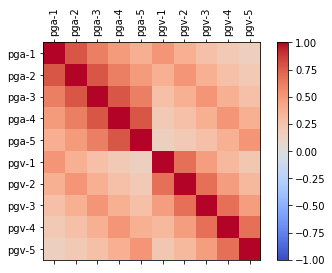

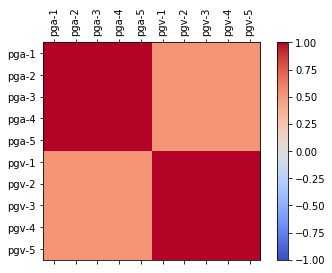

100.0
100.0
100.0
100.0
100.0
--- 0.5193114280700684 seconds ---


In [26]:
rup_ind = '108'
fn_fp = 'fp'
saveDir = 'output/'

EQHaz_file = saveDir + 'sim_s5_' + fn_fp + '_ucerf3_0_' + rup_ind + '_out.json'
l_seg_file = saveDir + 'sim_s5_' + fn_fp + '_ucerf3_0_' + rup_ind + '.json'

# EQHaz_file = 'sim_s5_fp_ucerf3_0_83_out.json'
# l_seg_file = 'sim_s5_fp_ucerf3_0_83.json'
# EQHaz_file = 'sim_s5_fn_ucerf3_0_83_out.json'
# l_seg_file = 'sim_s5_fn_ucerf3_0_83.json'

# EQHaz_file = 'sim_s5_fp_ucerf3_0_108_out.json'
# l_seg_file = 'sim_s5_fp_ucerf3_0_108.json'
# EQHaz_file = 'sim_s5_fn_ucerf3_0_108_out.json'
# l_seg_file = 'sim_s5_fn_ucerf3_0_108.json'

# EQHaz_file = 'sim_s5_fp_ucerf3_0_606_out.json'
# l_seg_file = 'sim_s5_fp_ucerf3_0_606.json'
# EQHaz_file = 'sim_s5_fn_ucerf3_0_606_out.json'
# l_seg_file = 'sim_s5_fn_ucerf3_0_606.json'

# EQHaz_file = 'sim_s5_fp_ucerf3_0_626_out.json'
# l_seg_file = 'sim_s5_fp_ucerf3_0_626.json'
# EQHaz_file = 'sim_s5_fn_ucerf3_0_626_out.json'
# l_seg_file = 'sim_s5_fn_ucerf3_0_626.json'

# EQHaz_file = 'output/' + EQHaz_file
# l_seg_file = 'output/' + l_seg_file


## Assessment parameters
nsamp = 10000
# d_w = 5 # ft
# sus_liq = 'very high'
# sus_land = 5
pipe_type = 'brittle'
flag_corr_h = True
flag_corr_p = True
A = Assessment()
A.read_inputs(EQHaz_file,l_seg_file)
A._create_IM_dict()
##
start_time = time.time()
A.perform_assess(nsamp, pipe_type, flag_corr_h, flag_corr_p)
print("--- %s seconds ---" % (time.time() - start_time))

In [61]:
## initialize arrays for getting probabilities
rr4prob = np.power(10,np.linspace(-2,3,201))
pga4prob = np.linspace(-4,1,5*25+1)
pgv4prob = np.linspace(0,7,7*25+1)
rr_cond = [1.60934/2] #0.16 km ~ 0.1 mile
pga_cond = 0.5
pgv_cond = 100
##
start_time = time.time()
A.get_probability(rr4prob, pga4prob, pgv4prob, rr_cond, pga_cond, pgv_cond)
print("--- %s seconds ---" % (time.time() - start_time))

--- 111.7349545955658 seconds ---


In [62]:
nsites = 0
leg_site = []
for i in A._DM_dict.keys():
    if 'site' in i:
        nsites += 1
        leg_site.append('site_'+str(nsites))

In [63]:
# Open target workbook and worksheet to overwrite
indjson = l_seg_file.find('.json')
saveName = l_seg_file[0:indjson] + '.xlsx'


# remove file if already exists
# if os.path.exists(saveName) is True:
#     # remove exsting file
#     os.remove(saveName)

    
if os.path.exists(saveName) is False:
    # create new instance of spreadsheet
    wb = openpyxl.Workbook(saveName)
    # Save file
    wb.save(saveName)
    wb.close()
    

# Open target workbook and worksheet to overwrite
wb = openpyxl.load_workbook(filename=saveName, read_only = False)


# worksheet names
sheetName1 = 'pdm'
sheetName2 = 'pdm_g_pgv'
sheetName3 = 'pdm_g_pga'
if sheetName1 in wb.sheetnames:
    wb.remove(wb[sheetName1])
if sheetName2 in wb.sheetnames:
    wb.remove(wb[sheetName2])
if sheetName3 in wb.sheetnames:
    wb.remove(wb[sheetName3])

    
# Create new worksheets
ws1 = wb.create_sheet(sheetName1)
ws2 = wb.create_sheet(sheetName2)
ws3 = wb.create_sheet(sheetName3)


##### store results into Excel - p(dm)
matOut = A._FR_dict['rr_arr']
for i in range(nsites):
    matOut = np.vstack([matOut,
                        A._FR_dict['site_'+str(i+1)]['p_leak'],
                        A._FR_dict['site_'+str(i+1)]['p_break']])
matOut = np.vstack([matOut,
                    A._FR_dict['p_leak_avg'],
                    A._FR_dict['p_break_avg']])
for i in range(nsites):
    matOut = np.vstack([matOut,
                        A._FR_dict['site_'+str(i+1)]['p_leak']*A._IM_in['eq_rup']['MeanAnnualRate'],
                        A._FR_dict['site_'+str(i+1)]['p_break']*A._IM_in['eq_rup']['MeanAnnualRate']])
matOut = np.vstack([matOut,
                    A._FR_dict['p_leak_avg']*A._IM_in['eq_rup']['MeanAnnualRate'],
                    A._FR_dict['p_break_avg']*A._IM_in['eq_rup']['MeanAnnualRate']])
colsHeader = np.hstack(['rr (repairs/km)',
                         np.hstack([['site_'+str(i+1)+': p_leak',
                                    'site_'+str(i+1)+': p_break'] for i in range(nsites)]),
                        'p_leak_avg','p_break_avg',
                         np.hstack([['site_'+str(i+1)+': rate_leak',
                                    'site_'+str(i+1)+': rate_break'] for i in range(nsites)]),
                        'rate_leak_avg','rate_break_avg'])
dfOut = {}
for i in range(len(colsHeader)):
    dfOut.update({colsHeader[i]: matOut[i]})
dfOut = pd.DataFrame(dfOut)
# Save data into new worksheet with user-defined dataframe.
rows = dataframe_to_rows(dfOut, index=False, header=True)
for r_idx, row in enumerate(rows, 1):
    for c_idx, value in enumerate(row, 1):
         ws1.cell(row=r_idx, column=c_idx, value=value)



# ##### store results into Excel - p(dm|pgv)
# matOut = np.exp(A._FR_dict['pga_arr'])
# for i in range(nsites):
#     matOut = np.vstack([matOut,
#                         A._FR_dict['site_'+str(i+1)]['p_leak_g_pgv'],
#                         A._FR_dict['site_'+str(i+1)]['p_break_g_pgv']])
# for i in range(nsites):
#     matOut = np.vstack([matOut,
#                         A._FR_dict['site_'+str(i+1)]['p_leak_g_pgv']*A._IM_in['eq_rup']['MeanAnnualRate'],
#                         A._FR_dict['site_'+str(i+1)]['p_break_g_pgv']*A._IM_in['eq_rup']['MeanAnnualRate']])
# colsHeader = np.hstack(['pga (g)',
#                         np.hstack([['site_'+str(i+1)+': p_leak_g_pgv',
#                                     'site_'+str(i+1)+': p_break_g_pgv'] for i in range(nsites)]),
#                         np.hstack([['site_'+str(i+1)+': rate_leak_g_pgv',
#                                     'site_'+str(i+1)+': rate_break_g_pgv'] for i in range(nsites)])])
# dfOut = {}
# for i in range(len(colsHeader)):
#     dfOut.update({colsHeader[i]: matOut[i]})
# dfOut = pd.DataFrame(dfOut)
# # Save data into new worksheet with user-defined dataframe.
# rows = dataframe_to_rows(dfOut, index=False, header=True)
# for r_idx, row in enumerate(rows, 1):
#     for c_idx, value in enumerate(row, 1):
#          ws2.cell(row=r_idx, column=c_idx, value=value)


# ##### store results into Excel - p(dm|pga)
# matOut = np.exp(A._FR_dict['pgv_arr'])
# for i in range(nsites):
#     matOut = np.vstack([matOut,
#                         A._FR_dict['site_'+str(i+1)]['p_leak_g_pga'],
#                         A._FR_dict['site_'+str(i+1)]['p_break_g_pga']])
# for i in range(nsites):
#     matOut = np.vstack([matOut,
#                         A._FR_dict['site_'+str(i+1)]['p_leak_g_pga']*A._IM_in['eq_rup']['MeanAnnualRate'],
#                         A._FR_dict['site_'+str(i+1)]['p_break_g_pga']*A._IM_in['eq_rup']['MeanAnnualRate']])
# colsHeader = np.hstack(['pgv (cm/s)',
#                         np.hstack([['site_'+str(i+1)+': p_leak_g_pga',
#                                     'site_'+str(i+1)+': p_break_g_pga'] for i in range(nsites)]),
#                         np.hstack([['site_'+str(i+1)+': rate_leak_g_pga',
#                                     'site_'+str(i+1)+': rate_break_g_pga'] for i in range(nsites)])])
# dfOut = {}
# for i in range(len(colsHeader)):
#     dfOut.update({colsHeader[i]: matOut[i]})
# dfOut = pd.DataFrame(dfOut)
# # Save data into new worksheet with user-defined dataframe.
# rows = dataframe_to_rows(dfOut, index=False, header=True)
# for r_idx, row in enumerate(rows, 1):
#     for c_idx, value in enumerate(row, 1):
#          ws3.cell(row=r_idx, column=c_idx, value=value)


if 'Sheet' in wb.sheetnames:
    # Remove sheetname = Sheet
    wb.remove(wb['Sheet'])
            
            
# Save file
wb.save(saveName)
wb.close()

In [64]:
indjson = l_seg_file.find('.json')
saveName_rr = l_seg_file[0:indjson] + '_rr' + '.out'

pga = np.asarray([A._DM_dict['site_'+str(i+1)]['pga'] for i in range(nsites)])
pgv = np.asarray([A._DM_dict['site_'+str(i+1)]['pgv'] for i in range(nsites)])
rr_pgv = np.asarray([A._DM_dict['site_'+str(i+1)]['rr_pgv'] for i in range(nsites)])
rr_pgd = np.asarray([A._DM_dict['site_'+str(i+1)]['rr_pgd'] for i in range(nsites)])
rr_leak = np.asarray([A._DM_dict['site_'+str(i+1)]['rr_leak'] for i in range(nsites)])
rr_break = np.asarray([A._DM_dict['site_'+str(i+1)]['rr_break'] for i in range(nsites)])
# E_rr_leak = [np.sum(i)/nsamp*A._IM_in['eq_rup']['MeanAnnualRate'] for i in rr_leak]
# E_rr_break = [np.sum(i)/nsamp*A._IM_in['eq_rup']['MeanAnnualRate'] for i in rr_break]
outMat = np.transpose(np.vstack([pga,pgv,rr_pgv,rr_pgd,rr_leak,rr_break]))

np.savetxt(saveName_rr, outMat, fmt='%.6f')

In [ ]:
[1 for i in A._DM_dict.keys() if 'site_' in i]

In [ ]:
plt.figure()
plt.semilogy(A._DM_dict['site_1']['rr_leak'],'o')
plt.semilogy([0,1000],[rr_cond[0],rr_cond[0]],'r')
# plt.semilogy(A._DM_dict['site_1']['rr_leak'][ind],'or')
plt.show()
print(len(ind[ind is True]))

In [ ]:
ind = A._DM_dict['site_1']['rr_leak'] > 1
aa = [1 for i in ind if i == True]
print(sum(aa))

In [ ]:
ind = A._DM_dict['site_1']['rr_break'] > 1
aa = [1 for i in ind if i == True]
print(sum(aa))

In [ ]:
plt.semilogy(A._DM_dict['site_1']['rr_break'],'o')

In [ ]:
pga = A._DM_dict['site_1']['pga']
pgv = A._DM_dict['site_1']['pgv']
ind_g_pgv = A._DM_dict['site_1']['ind4cond_g_pgv']
ind_g_pga = A._DM_dict['site_1']['ind4cond_g_pga']
x_pga = np.exp(A._DM_dict['pga_arr'])
x_pgv = np.exp(A._DM_dict['pgv_arr'])
rr_leak = A._DM_dict['site_1']['rr_leak']
rr_break = A._DM_dict['site_1']['rr_break']

In [ ]:
pga_cond = pga[ind_g_pgv]
pgv_cond = pgv[ind_g_pga]

In [ ]:
len(pga_cond)

In [ ]:
plt.figure()
plt.plot(pga_cond, rr_leak[ind_g_pgv],'or')
plt.plot(pga_cond, rr_break[ind_g_pgv],'o')
plt.show()

In [ ]:
plt.figure()
plt.plot(pgv_cond, rr_leak[ind_g_pga],'or')
plt.plot(pgv_cond, rr_break[ind_g_pga],'o')
plt.show()

In [ ]:
min(x_pga)

In [ ]:
plt.figure()
plt.scatter(A._DM_dict['site_'+str(1)]['p_leak_g_pga'],A._DM_dict['site_'+str(1)]['p_break_g_pga'])
plt.show()

In [ ]:
np.corrcoef(A._DM_dict['site_'+str(3)]['p_leak_g_pga'],A._DM_dict['site_'+str(3)]['p_break_g_pga'])

In [23]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Plot the surface.
pga = A._DM_dict['site_1']['pga']
pgv = A._DM_dict['site_1']['pgv']
rr_pgd = A._DM_dict['site_1']['rr_pgd']
rr_pgv = A._DM_dict['site_1']['rr_pgv']
rr_leak = A._DM_dict['site_1']['rr_leak']
rr_break = A._DM_dict['site_1']['rr_break']

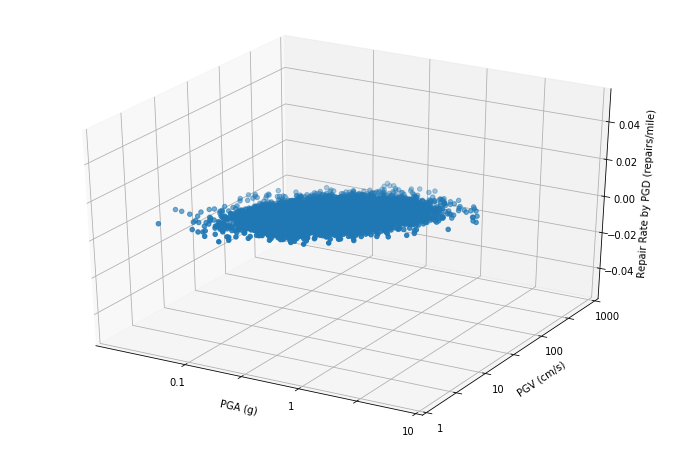

In [31]:
# plt, ax = plt.subplots(1,1, figsize=(12,8))
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
surf = ax.scatter(np.log10(pga), np.log10(pgv), rr_pgd*1.60934)
ax.set_xlabel('PGA (g)')
ax.set_ylabel('PGV (cm/s)')
ax.set_zlabel('Repair Rate by PGD (repairs/mile)')
xticks = [0.1,10**(-0.5),1,10**(0.5),10]
xtickslabel = [0.1,None,1,None,10]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xtickslabel)
yticks = [1,10**(0.5),10,10**(1.5),100,10**(2.5),1000]
ytickslabel = [1,None,10,None,100,None,1000]
ax.set_yticks(np.log10(yticks))
ax.set_yticklabels(ytickslabel)
plt.show()

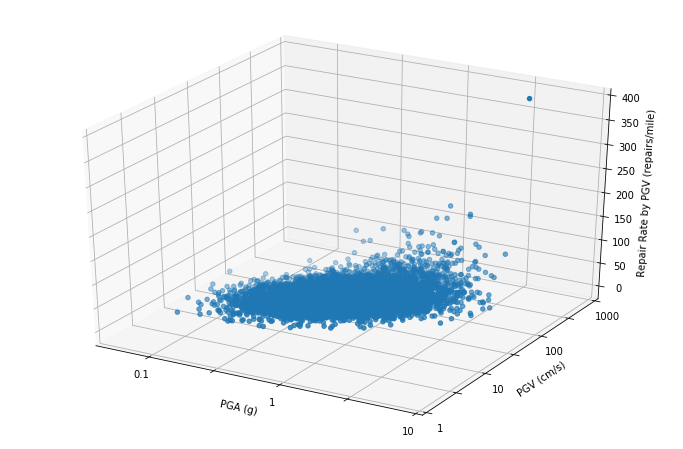

In [26]:
# plt, ax = plt.subplots(1,1, figsize=(12,8))
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
surf = ax.scatter(np.log10(pga), np.log10(pgv), rr_pgv*1.60934)
ax.set_xlabel('PGA (g)')
ax.set_ylabel('PGV (cm/s)')
ax.set_zlabel('Repair Rate by PGV (repairs/mile)')
xticks = [0.1,10**(-0.5),1,10**(0.5),10]
xtickslabel = [0.1,None,1,None,10]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xtickslabel)
yticks = [1,10**(0.5),10,10**(1.5),100,10**(2.5),1000]
ytickslabel = [1,None,10,None,100,None,1000]
ax.set_yticks(np.log10(yticks))
ax.set_yticklabels(ytickslabel)
plt.show()

In [ ]:
nx = 2
ny = 2
figsize = (16,12)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
case = 1

##
for i in range(nx):
    if i == 0:
        y = rr_pgd*1.60937
        ylabel = 'Repair Rate by PGD (repairs/mile)'
        ylims = [-0.025,0.325]
    elif i == 1:
        y = rr_pgv*1.60937
        ylabel = 'Repair Rate by PGV (repairs/mile)'
        ylims = [-25,525]
        
    for j in range(nx):
        if j == 0:
            x = pga
            xlabel = 'PGA (g)'
            xticks = [0.01,10**(-1.5),0.1,10**(-0.5),1,10**(0.5),10]
            xtickslabel = [0.01,None,0.1,None,1,None,10]
            xlims = np.log10([0.01,10])
        elif j == 1:
            x = pgv
            xlabel = 'PGV (cm/s)'
            xticks = [1,10**(0.5),10,10**(1.5),100,10**(2.5),1000]
            xtickslabel = [1,None,10,None,100,None,1000]
            xlims = np.log10([1,1000])
            
        if case == 1:
            ax[i][j].scatter(np.log10(x),y,ec='None',fc='None')
        
        elif case == 2:
            if (i == 0 and j == 0) or (i == 1 and j == 1):
                ax[i][j].scatter(np.log10(x),y,ec='k',fc='k',alpha=0.4)
            
        elif case == 3:
            ax[i][j].scatter(np.log10(x),y,ec='k',fc='k',alpha=0.4)
        
        ax[i][j].set_xlim(xlims)
        ax[i][j].set_ylim(ylims)
        ax[i][j].set_xlabel(xlabel,fontsize=fontsize_label,fontname=fontname)
        ax[i][j].set_ylabel(ylabel,fontsize=fontsize_label,fontname=fontname)
        ax[i][j].set_xticks(np.log10(xticks))
#         ax.set_xticks(np.log10(xticks))
        ax[i][j].set_xticklabels(xtickslabel,fontname=fontname)
#         ax[i][j].set_yticklabels(ax[i][j].get_yticklabels(),fontname=fontname)
        ax[i][j].tick_params(labelsize=fontsize_axis)
        
if case == 1:
    plt.savefig('0_' + rup_ind + '_' + fn_fp + '_rr_im_empty.png',dpi=100,format='png',quality=100,bbox_inches='tight')
elif case == 2:
    plt.savefig('0_' + rup_ind + '_' + fn_fp + '_rr_im_1_4.png',dpi=100,format='png',quality=100,bbox_inches='tight')
elif case == 3:
    plt.savefig('0_' + rup_ind + '_' + fn_fp + '_rr_im_all.png',dpi=100,format='png',quality=100,bbox_inches='tight')
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

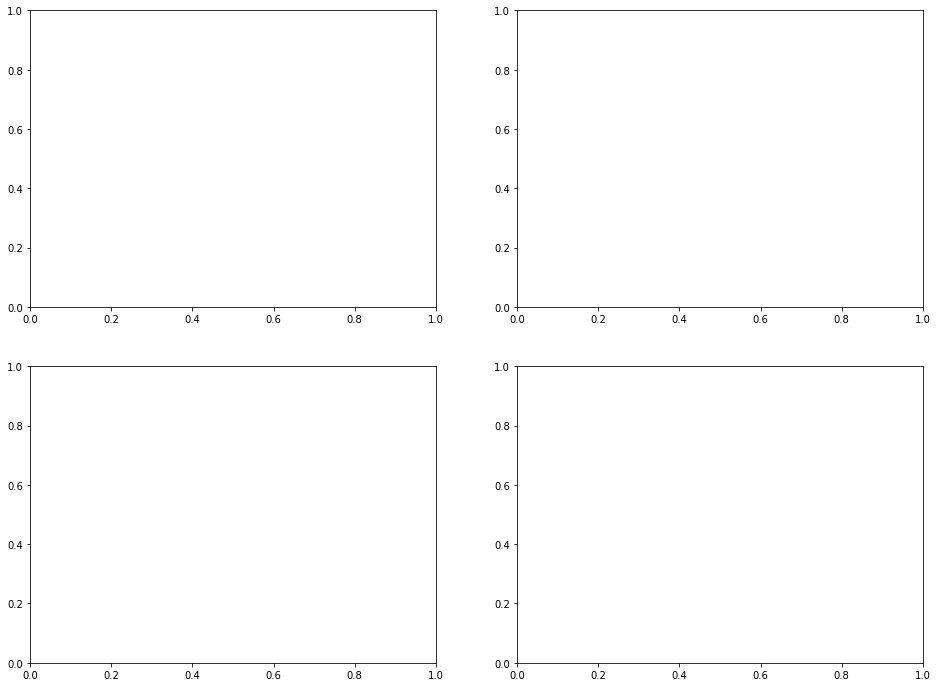

In [47]:
nx = 2
ny = 2
figsize = (16,6)
fig, ax = plt.subplots(nx, ny, figsize=figsize)
fontsize_label = 16
fontsize_axis = 12
fontname = 'arial'
ylims = [0.001,1000]
case = 2

##
for i in range(ny):
    if i == 0:
        y = rr_leak*1.60937
        ylabel = 'Number of leaks per mile'
        x = pga
        xlabel = 'PGA (g)'
        xticks = [0.01,10**(-1.5),0.1,10**(-0.5),1,10**(0.5),10]
        xtickslabel = [0.01,None,0.1,None,1,None,10]
        xlims = np.log10([0.01,10])
    elif i == 1:
        y = rr_break*1.60937
        ylabel = 'Number of breaks per mile'
        x = pgv
        xlabel = 'PGV (cm/s)'
        xticks = [1,10**(0.5),10,10**(1.5),100,10**(2.5),1000]
        xtickslabel = [1,None,10,None,100,None,1000]
        xlims = np.log10([1,1000])

        if case == 1:
            ax[i].scatter(np.log10(x),y,ec='None',fc='None')
        
        elif case == 2:
            ax[i].scatter(np.log10(x),y,ec='k',fc='k',alpha=0.4)
        
        ax[i].set_ylim(ylims)
        ax[i].set_xlim(xlims)
        ax[i].set_xlabel(xlabel,fontsize=fontsize_label,fontname=fontname)
        ax[i].set_ylabel(ylabel,fontsize=fontsize_label,fontname=fontname)
        ax[i].set_xticks(np.log10(xticks))
        ax[i].set_xticklabels(xtickslabel,fontname=fontname)
#         ax[i][j].set_yticklabels(ax[i][j].get_yticklabels(),fontname=fontname)
        ax[i].tick_params(labelsize=fontsize_axis)
        ax[i].set_yscale('log')

if case == 1:
    plt.savefig('0_' + rup_ind + '_' + fn_fp + '_rr_leak_break_empty.png',dpi=100,format='png',quality=100,bbox_inches='tight')
elif case == 2:
    plt.savefig('0_' + rup_ind + '_' + fn_fp + '_rr_leak_break_all.png',dpi=100,format='png',quality=100,bbox_inches='tight')
plt.show()

In [7]:
A = 'PGA'

In [8]:
A.lower()

'pga'

In [10]:
'a' in A.lower()

True

In [11]:
def main():
    print('in main')

In [12]:
if __name__ == "__main__":
    main()

in main


In [13]:
__name__

'__main__'

In [21]:
from importlib import import_module

In [32]:
param = 'sfr'
method = 'wells_coppersmith_1994'
mod_path = os.getcwd()+'\\edp\\' + param + '.py'
mod_path = mod_path.replace('\\','/')

In [37]:
a1 = import_module('src.edp.'+param)

In [39]:
a2 = getattr(a1, method)

In [44]:
a2(M=7,d_type='max',fault_type='all')

0.27999999999999936

In [45]:
-5.46+0.82*7

0.27999999999999936